To start with, I have taken ideas from the following code esp. to see how GCN works. Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

In [1]:
# import libraries

import os
import pandas as pd

In [2]:
# Import Libraries for Graph, GNN, and GCN

import stellargraph as sg
from stellargraph import StellarGraph

from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
drop_rows_with_na = 1

In [5]:
df = pd.DataFrame();
data_file = "small-stock-price--all-merged.csv"
# stock-price--all-merged.csv"
df = pd.read_csv("./data/" + data_file);
df.head()

,Unnamed: 0,Ticker,Date,Low,Open,Volume,High,Close,Adjusted Close
0,0,WY,03-05-1973,18.458332,18.833332,116700,19.333332,19.083332,1.415370
1,1,WY,04-05-1973,19.583332,19.583332,256800,19.958332,19.666668,1.458635
2,2,WY,07-05-1973,19.541668,19.666668,55800,19.708332,19.583332,1.452454
3,3,WY,08-05-1973,19.416668,19.583332,80100,19.583332,19.583332,1.452454
4,4,WY,09-05-1973,19.541668,19.583332,66900,19.791668,19.666668,1.458635


In [6]:
df_s =  df[ ['Ticker', 'Date', 'Adjusted Close'] ];
df_s

,Ticker,Date,Adjusted Close
0,WY,03-05-1973,1.415370
1,WY,04-05-1973,1.458635
2,WY,07-05-1973,1.452454
3,WY,08-05-1973,1.452454
4,WY,09-05-1973,1.458635
...,...,...,...
74640,ZTS,06-12-2022,153.050003
74641,ZTS,07-12-2022,150.250000
74642,ZTS,08-12-2022,153.679993
74643,ZTS,09-12-2022,153.389999


In [7]:
df_s.shape

(74645, 3)

In [8]:
# df_s["Date"] = df_s["Date"].astype('datetime64[ns]')
# df_s = df_s.sort_values( by = 'Date', ascending = True )
# df_s

In [9]:
# DataFrame.pivot_table
df_s_pivot = df_s.pivot_table(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

Date,01-02-1971,01-02-1972,01-02-1973,01-02-1974,01-02-1977,01-02-1978,01-02-1979,01-02-1980,01-02-1982,01-02-1983,...,31-12-2009,31-12-2010,31-12-2012,31-12-2013,31-12-2014,31-12-2015,31-12-2018,31-12-2019,31-12-2020,31-12-2021
Ticker,,,,,,,,,,,,,,,,,,,,,
WY,NaN,NaN,NaN,1.885100,2.012056,1.225056,1.536462,1.821926,1.541208,2.259849,...,10.259043,12.284119,19.117323,22.297297,26.165010,22.732100,18.656504,27.158773,30.700102,38.965187
WYNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.204308,73.964508,91.729721,165.950317,131.287323,62.666248,94.978737,137.714386,112.830002,85.040001
XEL,NaN,NaN,NaN,1.008796,1.184458,1.043928,0.973664,0.828116,1.033891,1.214571,...,13.687512,15.889650,19.528238,21.244215,28.359310,29.449564,44.527931,58.942188,63.521393,66.316925
XLEFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.137200,0.151600,0.058500,0.087000,0.098000,0.060700,0.193100,0.085000,0.206000,0.233300
XOM,0.206687,0.227523,0.301862,0.285793,0.439392,0.399459,0.469953,0.623950,0.703863,0.797839,...,41.415253,45.610184,56.669090,68.070015,63.947742,55.767654,54.603767,58.553173,37.350468,58.855209
XYL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.708212,30.786577,34.347809,33.462044,63.582310,76.037262,99.533028,118.379974
YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.549164,28.009109,39.412952,45.784870,45.027046,46.153839,85.595673,95.365997,104.756699,136.241257
ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.388924,47.576355,59.737072,84.346863,103.541145,94.434494,97.903503,142.326599,147.687973,122.551712
ZION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.412998,1.398868,...,10.710710,20.264502,17.972174,25.278742,24.188005,23.337999,36.242443,47.476818,41.223854,61.467342


In [10]:
df_s_pivot = df_s.pivot(index = 'Ticker', columns = 'Date', values = 'Adjusted Close')
df_s_pivot

Date,01-02-1971,01-02-1972,01-02-1973,01-02-1974,01-02-1977,01-02-1978,01-02-1979,01-02-1980,01-02-1982,01-02-1983,...,31-12-2009,31-12-2010,31-12-2012,31-12-2013,31-12-2014,31-12-2015,31-12-2018,31-12-2019,31-12-2020,31-12-2021
Ticker,,,,,,,,,,,,,,,,,,,,,
WY,NaN,NaN,NaN,1.885100,2.012056,1.225056,1.536462,1.821926,1.541208,2.259849,...,10.259043,12.284119,19.117323,22.297297,26.165010,22.732100,18.656504,27.158773,30.700102,38.965187
WYNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.204308,73.964508,91.729721,165.950317,131.287323,62.666248,94.978737,137.714386,112.830002,85.040001
XEL,NaN,NaN,NaN,1.008796,1.184458,1.043928,0.973664,0.828116,1.033891,1.214571,...,13.687512,15.889650,19.528238,21.244215,28.359310,29.449564,44.527931,58.942188,63.521393,66.316925
XLEFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.137200,0.151600,0.058500,0.087000,0.098000,0.060700,0.193100,0.085000,0.206000,0.233300
XOM,0.206687,0.227523,0.301862,0.285793,0.439392,0.399459,0.469953,0.623950,0.703863,0.797839,...,41.415253,45.610184,56.669090,68.070015,63.947742,55.767654,54.603767,58.553173,37.350468,58.855209
XYL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.708212,30.786577,34.347809,33.462044,63.582310,76.037262,99.533028,118.379974
YUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.549164,28.009109,39.412952,45.784870,45.027046,46.153839,85.595673,95.365997,104.756699,136.241257
ZBH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.388924,47.576355,59.737072,84.346863,103.541145,94.434494,97.903503,142.326599,147.687973,122.551712
ZION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.412998,1.398868,...,10.710710,20.264502,17.972174,25.278742,24.188005,23.337999,36.242443,47.476818,41.223854,61.467342


In [11]:
# df_s_pivot.corr()

In [12]:
df_s_transpose = df_s_pivot.T
df_s_transpose

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
01-02-1971,NaN,NaN,NaN,NaN,0.206687,NaN,NaN,NaN,NaN,NaN
01-02-1972,NaN,NaN,NaN,NaN,0.227523,NaN,NaN,NaN,NaN,NaN
01-02-1973,NaN,NaN,NaN,NaN,0.301862,NaN,NaN,NaN,NaN,NaN
01-02-1974,1.885100,NaN,1.008796,NaN,0.285793,NaN,NaN,NaN,NaN,NaN
01-02-1977,2.012056,NaN,1.184458,NaN,0.439392,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
31-12-2015,22.732100,62.666248,29.449564,0.0607,55.767654,33.462044,46.153839,94.434494,23.337999,45.749474
31-12-2018,18.656504,94.978737,44.527931,0.1931,54.603767,63.582310,85.595673,97.903503,36.242443,83.438843
31-12-2019,27.158773,137.714386,58.942188,0.0850,58.553173,76.037262,95.365997,142.326599,47.476818,129.921722


In [13]:
if drop_rows_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis=0);
    #df_s_transpose["Date"] = df_s_transpose["Date"].astype('datetime64[ns]')
    #df_s_transpose.sort_values(by='Date', ascending=False)
    df_s_transpose.to_csv('./data/ticker-columns-small-stock-price-all-merged.csv');
   
df_s_transpose.head(100)

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
01-02-2013,20.883371,103.048119,20.478704,0.05850,58.954189,24.504324,39.336575,65.839821,20.096922,28.952980
01-02-2016,19.782536,60.773312,31.622816,0.06070,54.580055,32.655289,46.492840,91.157463,19.234612,41.104145
01-02-2017,24.578880,90.668427,34.436993,0.05200,61.433521,45.699051,58.627979,110.029305,36.666920,53.362606
01-02-2018,30.465961,160.564102,39.170780,0.25350,68.485405,70.484642,76.855545,119.965019,47.955444,75.582741
01-02-2019,22.829893,121.059235,47.121704,0.19310,60.793613,66.850998,87.653610,110.061195,42.958954,85.167404
...,...,...,...,...,...,...,...,...,...,...
02-03-2022,38.706863,88.629997,66.179787,0.19747,78.315941,87.285889,120.254913,121.906052,66.889503,194.954529
02-04-2013,21.841364,101.328606,21.882168,0.09600,59.686665,23.910618,41.854408,67.692314,20.567228,30.390823
02-04-2014,20.968288,195.460785,23.204342,0.08700,66.350578,33.721264,46.930309,87.613419,26.773081,27.890862


In [14]:
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

C:\Users\sayed\AppData\Local\Temp\ipykernel_14476\3926235044.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')


# Note: the above data has null and missing values. That will be addressed.

In [15]:
# Experiment find correlations
# Ref: https://towardsdatascience.com/time-series-and-correlations-with-stock-market-data-using-python-e66774e3a16f

In [16]:
# df_s_transpose = df_s_transpose.fillna(0);

# Find Kendall Correlation Coefficient

In [17]:
df_s_transpose_kendall = df_s_transpose.corr(method='kendall')
df_s_transpose_kendall

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.000000,-0.008544,0.496151,0.287353,0.135625,0.540468,0.517248,0.464727,0.583282,0.533627
WYNN,-0.008544,1.000000,-0.253453,0.033290,0.142122,-0.108556,-0.152433,-0.059714,0.021557,-0.219898
XEL,0.496151,-0.253453,1.000000,0.382282,-0.096051,0.771179,0.795176,0.623614,0.563132,0.840853
XLEFF,0.287353,0.033290,0.382282,1.000000,-0.016651,0.414277,0.429430,0.299577,0.455170,0.403436
XOM,0.135625,0.142122,-0.096051,-0.016651,1.000000,-0.029698,-0.033426,-0.114000,0.089203,-0.124349
XYL,0.540468,-0.108556,0.771179,0.414277,-0.029698,1.000000,0.829498,0.655981,0.670453,0.812713
YUM,0.517248,-0.152433,0.795176,0.429430,-0.033426,0.829498,1.000000,0.630930,0.682253,0.841465
ZBH,0.464727,-0.059714,0.623614,0.299577,-0.114000,0.655981,0.630930,1.000000,0.472226,0.640518
ZION,0.583282,0.021557,0.563132,0.455170,0.089203,0.670453,0.682253,0.472226,1.000000,0.621643


# Kendall Correlation Coefficient based Adjacency Graph Matrix

In [18]:
df_s_transpose_kendall[df_s_transpose_kendall >= 0.3 ] = 1
df_s_transpose_kendall[df_s_transpose_kendall < 0.3 ] = 0
df_s_transpose_kendall

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Ticker,,,,,,,,,,
WY,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
WYNN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XEL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
XLEFF,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
XOM,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
XYL,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
YUM,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
ZBH,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
ZION,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


Create and visualize the Graphs

In [19]:
import networkx as nx


In [20]:

Graph_kendall = nx.Graph(df_s_transpose_kendall)

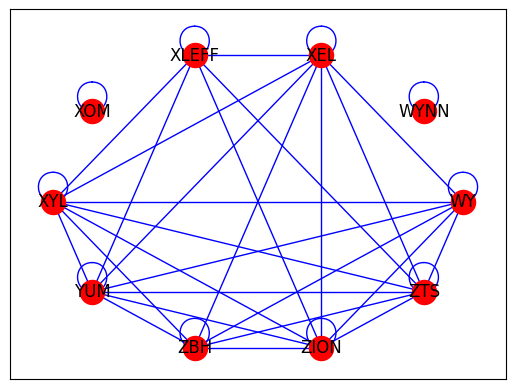

In [21]:
nx.draw_networkx(Graph_kendall, pos=nx.circular_layout(Graph_kendall), node_color='r', edge_color='b')

# Create GCN layer. Kendall

# Find all stocks = nodes

In [22]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_kendall.index.to_list()
all_stock_nodes

['WY', 'WYNN', 'XEL', 'XLEFF', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

# Find all edges between nodes

In [23]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_kendall[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)
            
source, target, edge_feature            

(['WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WY',
  'WYNN',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XEL',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XLEFF',
  'XOM',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'XYL',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'YUM',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZBH',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZION',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS',
  'ZTS'],
 ['WY',
  'XEL',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WYNN',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZION',
  'ZTS',
  'XOM',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WY',
  'XEL',
  'XLEFF',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  'WY',
  'XEL',
  'XYL',
  'YUM',
  'ZBH',
  'ZION',
  'ZTS',
  '

In [24]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_edges = pd.DataFrame(
    {"source": source, "target": target}
)

kendall_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


kendall_edges[:10]

,source,target
0,WY,WY
1,WY,XEL
2,WY,XYL
3,WY,YUM
4,WY,ZBH
5,WY,ZION
6,WY,ZTS
7,WYNN,WYNN
8,XEL,WY
9,XEL,XEL


In [25]:
# Graph with No Feature Data, No node data, only edges

kendall_graph = StellarGraph(edges = kendall_edges, node_type_default="corner", edge_type_default="line")
#kendall_graph = StellarGraph(nodes = all_stock_nodes, edges = kendall_edges)
# graph = sg.StellarGraph(all_stock_nodes, square_edges)
print(kendall_graph.info())

In [26]:
# Trying to have the time series data as part of the nodes

In [27]:
df_s_transpose

Ticker,WY,WYNN,XEL,XLEFF,XOM,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,
2013-01-02,20.883371,103.048119,20.478704,0.0585,58.954189,24.504324,39.336575,65.839821,20.096922,28.952980
2016-01-02,19.782536,60.773312,31.622816,0.0607,54.580055,32.655289,46.492840,91.157463,19.234612,41.104145
2017-01-02,24.578880,90.668427,34.436993,0.0520,61.433521,45.699051,58.627979,110.029305,36.666920,53.362606
2018-01-02,30.465961,160.564102,39.170780,0.2535,68.485405,70.484642,76.855545,119.965019,47.955444,75.582741
2019-01-02,22.829893,121.059235,47.121704,0.1931,60.793613,66.850998,87.653610,110.061195,42.958954,85.167404
...,...,...,...,...,...,...,...,...,...,...
2015-12-31,22.732100,62.666248,29.449564,0.0607,55.767654,33.462044,46.153839,94.434494,23.337999,45.749474
2018-12-31,18.656504,94.978737,44.527931,0.1931,54.603767,63.582310,85.595673,97.903503,36.242443,83.438843
2019-12-31,27.158773,137.714386,58.942188,0.0850,58.553173,76.037262,95.365997,142.326599,47.476818,129.921722


# Structure the Feature Matrix so that it can be passed to the GCN

In [28]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace=False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
df_s_transpose_feature['WY'].values

array([20.88337135, 19.78253555, 24.57888031, ..., 27.15877342,
       30.70010185, 38.96518707])

In [29]:
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([20.88337135, 19.78253555, 24.57888031, ..., 27.15877342,
        30.70010185, 38.96518707]),
 array([103.04811859,  60.77331161,  90.66842651, ..., 137.71438599,
        112.83000183,  85.04000092]),
 array([20.47870445, 31.62281609, 34.43699265, ..., 58.94218826,
        63.52139282, 66.31692505]),
 array([0.0585, 0.0607, 0.052 , ..., 0.085 , 0.206 , 0.2333]),
 array([58.9541893 , 54.58005524, 61.43352127, ..., 58.55317307,
        37.35046768, 58.85520935]),
 array([ 24.50432396,  32.6552887 ,  45.6990509 , ...,  76.03726196,
         99.53302765, 118.37997437]),
 array([ 39.33657455,  46.49283981,  58.62797928, ...,  95.36599731,
        104.75669861, 136.24125671]),
 array([ 65.83982086,  91.15746307, 110.0293045 , ..., 142.32659912,
        147.68797302, 122.55171204]),
 array([20.09692192, 19.23461151, 36.66691971, ..., 47.47681808,
        41.22385406, 61.46734238]),
 array([ 28.95298004,  41.10414505,  53.36260605, ..., 129.92172241,
        163.39428711, 242.25260925])

In [30]:
kendall_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)

kendall_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
WY,20.883371,19.782536,24.578880,30.465961,22.829893,29.335859,38.444767,20.438263,20.207153,27.167219,...,22.440746,25.966742,30.759796,22.297297,26.165010,22.732100,18.656504,27.158773,30.700102,38.965187
WYNN,103.048119,60.773312,90.668427,160.564102,121.059235,101.760002,88.190002,95.828918,77.032745,95.645653,...,95.906380,119.333656,63.900002,165.950317,131.287323,62.666248,94.978737,137.714386,112.830002,85.040001
XEL,20.478704,31.622816,34.436993,39.170780,47.121704,60.920322,67.090782,20.990484,32.360889,36.869530,...,43.953335,58.581844,65.110001,21.244215,28.359310,29.449564,44.527931,58.942188,63.521393,66.316925
XLEFF,0.058500,0.060700,0.052000,0.253500,0.193100,0.229000,0.190360,0.058500,0.060700,0.052000,...,0.193100,0.085000,0.165000,0.087000,0.098000,0.060700,0.193100,0.085000,0.206000,0.233300
XOM,58.954189,54.580055,61.433521,68.485405,60.793613,40.703136,77.745811,58.928879,58.677826,62.055080,...,63.164169,56.023117,109.925072,68.070015,63.947742,55.767654,54.603767,58.553173,37.350468,58.855209
XYL,24.504324,32.655289,45.699051,70.484642,66.850998,94.986130,103.572617,24.147791,34.928352,46.243382,...,62.495926,74.010635,102.157166,30.786577,34.347809,33.462044,63.582310,76.037262,99.533028,118.379974
YUM,39.336575,46.492840,58.627979,76.855545,87.653610,99.449394,121.249428,38.907013,48.458130,59.260616,...,83.841331,95.881447,117.710518,45.784870,45.027046,46.153839,85.595673,95.365997,104.756699,136.241257
ZBH,65.839821,91.157463,110.029305,119.965019,110.061195,147.505844,119.609459,67.201973,89.647835,110.382118,...,106.967766,131.230042,113.349998,84.346863,103.541145,94.434494,97.903503,142.326599,147.687973,122.551712
ZION,20.096922,19.234612,36.666920,47.955444,42.958954,42.419575,67.199493,20.197556,19.126860,40.254669,...,41.601864,44.024956,51.520054,25.278742,24.188005,23.337999,36.242443,47.476818,41.223854,61.467342
ZTS,28.952980,41.104145,53.362606,75.582741,85.167404,153.838516,197.738586,32.304829,40.281288,51.983208,...,87.815514,125.573006,150.779999,30.710964,40.783527,45.749474,83.438843,129.921722,163.394287,242.252609


# Graph with feature as part of Nodes

In [31]:
kendall_graph_with_node_features = StellarGraph(kendall_graph_node_data, edges = kendall_edges, node_type_default = "corner", edge_type_default = "line")
print(kendall_graph_with_node_features.info())


StellarGraph: Undirected multigraph
 Nodes: 10, Edges: 62

 Node types:
  corner: [10]
    Features: float32 vector, length 2483
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [62]
        Weights: all 1 (default)
        Features: none


In [32]:
# Generator
generator = FullBatchNodeGenerator(kendall_graph_with_node_features, method = "gcn")

Using GCN (local pooling) filters...


No need for this block

Graph with feature as part of both Nodes and edges
although Edge data is not required


kendall_graph_with_edge_features = StellarGraph(kendall_graph_node_data, edges = kendall_edges, node_type_default="corner", edge_type_default="line")
print(kendall_graph_with_edge_features.info())
generator = FullBatchNodeGenerator(kendall_graph_with_edge_features, method = "gcn")

In [33]:
# Train Test Split

In [34]:
train_subjects, test_subjects = model_selection.train_test_split(
    kendall_graph_node_data #, train_size = 6, test_size = 4
)
# , train_size=6, test_size=None, stratify=kendall_graph_node_data

val_subjects, test_subjects_ = model_selection.train_test_split(
    test_subjects #, test_size = 2
)

#, train_size=500, test_size=None, stratify=test_subjects

#val_subjects, test_subjects = model_selection.train_test_split(
#    test_subjects, train_size=500, test_size=None, stratify=test_subjects
#)

train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_.shape

((7, 2483), (3, 2483), (2, 2483), (1, 2483))

In [35]:
kendall_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
WY,20.883371,19.782536,24.578880,30.465961,22.829893,29.335859,38.444767,20.438263,20.207153,27.167219,...,22.440746,25.966742,30.759796,22.297297,26.165010,22.732100,18.656504,27.158773,30.700102,38.965187
WYNN,103.048119,60.773312,90.668427,160.564102,121.059235,101.760002,88.190002,95.828918,77.032745,95.645653,...,95.906380,119.333656,63.900002,165.950317,131.287323,62.666248,94.978737,137.714386,112.830002,85.040001
XEL,20.478704,31.622816,34.436993,39.170780,47.121704,60.920322,67.090782,20.990484,32.360889,36.869530,...,43.953335,58.581844,65.110001,21.244215,28.359310,29.449564,44.527931,58.942188,63.521393,66.316925
XLEFF,0.058500,0.060700,0.052000,0.253500,0.193100,0.229000,0.190360,0.058500,0.060700,0.052000,...,0.193100,0.085000,0.165000,0.087000,0.098000,0.060700,0.193100,0.085000,0.206000,0.233300
XOM,58.954189,54.580055,61.433521,68.485405,60.793613,40.703136,77.745811,58.928879,58.677826,62.055080,...,63.164169,56.023117,109.925072,68.070015,63.947742,55.767654,54.603767,58.553173,37.350468,58.855209
XYL,24.504324,32.655289,45.699051,70.484642,66.850998,94.986130,103.572617,24.147791,34.928352,46.243382,...,62.495926,74.010635,102.157166,30.786577,34.347809,33.462044,63.582310,76.037262,99.533028,118.379974
YUM,39.336575,46.492840,58.627979,76.855545,87.653610,99.449394,121.249428,38.907013,48.458130,59.260616,...,83.841331,95.881447,117.710518,45.784870,45.027046,46.153839,85.595673,95.365997,104.756699,136.241257
ZBH,65.839821,91.157463,110.029305,119.965019,110.061195,147.505844,119.609459,67.201973,89.647835,110.382118,...,106.967766,131.230042,113.349998,84.346863,103.541145,94.434494,97.903503,142.326599,147.687973,122.551712
ZION,20.096922,19.234612,36.666920,47.955444,42.958954,42.419575,67.199493,20.197556,19.126860,40.254669,...,41.601864,44.024956,51.520054,25.278742,24.188005,23.337999,36.242443,47.476818,41.223854,61.467342
ZTS,28.952980,41.104145,53.362606,75.582741,85.167404,153.838516,197.738586,32.304829,40.281288,51.983208,...,87.815514,125.573006,150.779999,30.710964,40.783527,45.749474,83.438843,129.921722,163.394287,242.252609


In [36]:
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 

In [37]:
train_gen = generator.flow(train_subjects.index, train_targets)

# This was there, but for classification, model does not match. I am changing
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator , dropout=0.5
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


In [48]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()

#x_out = Conv1D(filters = 2, kernel_size = 2)(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)
#x_out = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
x_out, 
x_inp, x_out

([<KerasTensor: shape=(1, 10, 2483) dtype=float32 (created by layer 'input_9')>,
  <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_10')>,
  <KerasTensor: shape=(1, None, 2) dtype=int64 (created by layer 'input_11')>,
  <KerasTensor: shape=(1, None) dtype=float32 (created by layer 'input_12')>],
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices_2')>)

# Experiment with Models

In [39]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

# layer_sizes = [32, 1, 32, 1, 32, 1]
# activations = ["relu", 'linear', "relu", 'linear',"relu", 'linear']

layer_sizes = [32, 32]
activations = ["relu", "relu"]

gcn = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator) #, dropout = 0.5
x_inp, x_out = gcn.in_out_tensors()
xout = x_out

#x_out = Conv1D(filters = 7, kernel_size = 7)(x_out)
input_shape = (4, 10, 128)
x_out = Conv1D(32, 3, activation = 'relu', input_shape = x_out[1:] )(x_out)
#x_out = MaxPool1D(pool_size=2)(x_out)
#x_out = Conv1D(filters = 32, kernel_size = sum(layer_sizes))(x_out)
#prediction = keras.layers.Reshape((-1,))(prediction)
#x_out = keras.layers.Reshape((1,16))(x_out)

# Generator
#generator2 = FullBatchNodeGenerator(x_out, method = "gcn")
gcn2 = GCN(layer_sizes = layer_sizes, activations = activations, generator = generator)#(x_out) #, dropout = 0.5

# predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
#x_out, 
x_inp, x_out, type(xout),  vars(gcn), 
x_out[1:]

<KerasTensor: shape=(0, None, 32) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [40]:
import tensorflow as tf
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x)
#print(y.shape)

#https://keras.io/api/layers/convolution_layers/convolution1d
x_out_cnn = Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x_out)
x, 
input_shape[1:], x_out_cnn

((10, 128),
 <KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'conv1d_2')>)

In [41]:
# Not my code
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.282295]]


x_out, vars(gcn)

In [42]:
# Models

In [49]:
# loss functions: https://keras.io/api/losses/

model = Model(inputs=x_inp, outputs=predictions)
'''
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.1),
    loss=losses.MeanSquaredError(),
    metrics=["acc"],
)
'''
model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.1), metrics=['mean_squared_error'])

In [50]:
len(x_inp) , predictions.shape, print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(1, 10, 2483)]      0           []                               
                                                                                                  
 input_11 (InputLayer)          [(1, None, 2)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(1, None)]          0           []                               
                                                                                                  
 dropout_6 (Dropout)            (1, 10, 2483)        0           ['input_9[0][0]']                
                                                                                            

(4, TensorShape([1, None, 2483]), None)

In [51]:
len(val_subjects)
test_subjects_ = test_subjects[:len(val_subjects)]

In [52]:
# hard coded size adjustments
test_subjects_ = test_subjects[:len(val_subjects)]

val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]

train_gen[:1][:4]

Epoch 1/100
1/1 - 1s - loss: 54.2830 - mean_squared_error: 4544.5811 - val_loss: 3221.1807 - val_mean_squared_error: 11101200.0000 - 793ms/epoch - 793ms/step
Epoch 2/100
1/1 - 0s - loss: 3616.7222 - mean_squared_error: 15372037.0000 - val_loss: 2925.7412 - val_mean_squared_error: 8936014.0000 - 50ms/epoch - 50ms/step
Epoch 3/100
1/1 - 0s - loss: 3173.1536 - mean_squared_error: 11496638.0000 - val_loss: 275.8553 - val_mean_squared_error: 117168.0312 - 48ms/epoch - 48ms/step
Epoch 4/100
1/1 - 0s - loss: 287.4754 - mean_squared_error: 141009.7969 - val_loss: 670.1915 - val_mean_squared_error: 539211.8750 - 48ms/epoch - 48ms/step
Epoch 5/100
1/1 - 0s - loss: 767.6584 - mean_squared_error: 756473.8750 - val_loss: 77.0201 - val_mean_squared_error: 7406.3047 - 51ms/epoch - 51ms/step
Epoch 6/100
1/1 - 0s - loss: 53.1961 - mean_squared_error: 4414.9419 - val_loss: 76.9995 - val_mean_squared_error: 7403.0889 - 50ms/epoch - 50ms/step
Epoch 7/100
1/1 - 0s - loss: 53.1811 - mean_squared_error: 4412

1/1 - 0s - loss: 48.9686 - mean_squared_error: 3830.1099 - val_loss: 70.9671 - val_mean_squared_error: 6518.7085 - 50ms/epoch - 50ms/step
Epoch 56/100
1/1 - 0s - loss: 48.8672 - mean_squared_error: 3817.1697 - val_loss: 70.8247 - val_mean_squared_error: 6498.9766 - 52ms/epoch - 52ms/step
Epoch 57/100
1/1 - 0s - loss: 48.7655 - mean_squared_error: 3804.2478 - val_loss: 70.6820 - val_mean_squared_error: 6479.2461 - 52ms/epoch - 52ms/step
Epoch 58/100
1/1 - 0s - loss: 48.6636 - mean_squared_error: 3791.3435 - val_loss: 70.5390 - val_mean_squared_error: 6459.5156 - 43ms/epoch - 43ms/step
Epoch 59/100
1/1 - 0s - loss: 48.5614 - mean_squared_error: 3778.4570 - val_loss: 70.3956 - val_mean_squared_error: 6439.7842 - 38ms/epoch - 38ms/step
Epoch 60/100
1/1 - 0s - loss: 48.4590 - mean_squared_error: 3765.5867 - val_loss: 70.2518 - val_mean_squared_error: 6420.0513 - 53ms/epoch - 53ms/step
Epoch 61/100
1/1 - 0s - loss: 48.3563 - mean_squared_error: 3752.7329 - val_loss: 70.1076 - val_mean_square

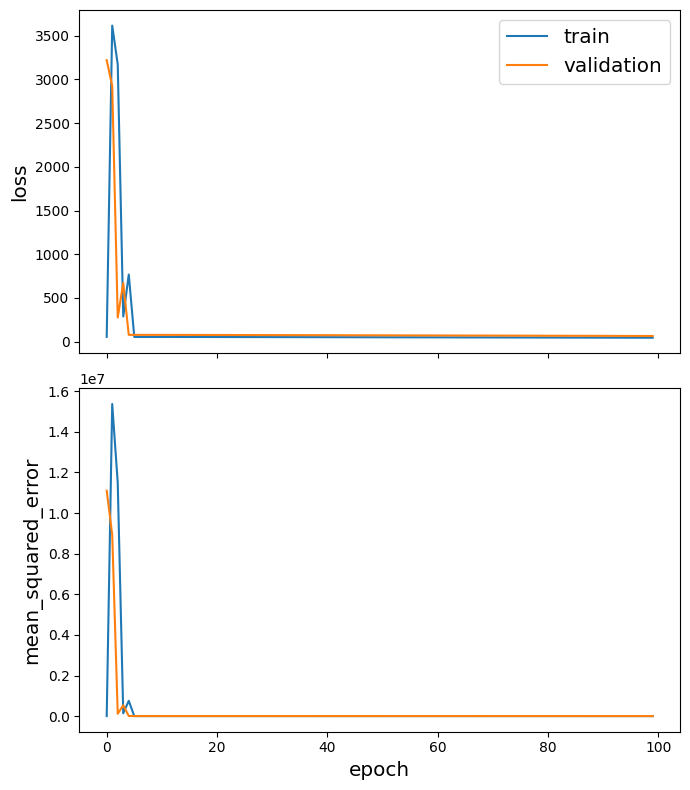

In [53]:
# https://keras.io/api/callbacks/early_stopping/
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = "val_mean_squared_error", patience = 50, restore_best_weights = True)

data_valid = val_gen #[:1][:4];
train_gen_data = train_gen #[:1][:4];

history = model.fit( train_gen_data, epochs = 100, validation_data = data_valid, verbose = 2,    
    # shuffling = true means shuffling the whole graph
    shuffle = False, callbacks = [es_callback],
)
sg.utils.plot_history(history)

# [1]

In [54]:
val_subjects, 
test_subjects

,0,1,2,3,4,5,6,7,8,9,...,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482
XEL,20.478704,31.622816,34.436993,39.170780,47.121704,60.920322,67.090782,20.990484,32.360889,36.869530,...,43.953335,58.581844,65.110001,21.244215,28.359310,29.449564,44.527931,58.942188,63.521393,66.316925
ZBH,65.839821,91.157463,110.029305,119.965019,110.061195,147.505844,119.609459,67.201973,89.647835,110.382118,...,106.967766,131.230042,113.349998,84.346863,103.541145,94.434494,97.903503,142.326599,147.687973,122.551712
ZTS,28.952980,41.104145,53.362606,75.582741,85.167404,153.838516,197.738586,32.304829,40.281288,51.983208,...,87.815514,125.573006,150.779999,30.710964,40.783527,45.749474,83.438843,129.921722,163.394287,242.252609


In [55]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    

1/1 [==============================] - 0s 46ms/step - loss: 68.4568 - mean_squared_error: 6829.6040

Test Set Metrics:
	loss: 68.4568
	mean_squared_error: 6829.6040


# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [56]:
all_nodes = kendall_graph_node_data.index;
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

all_predictions, all_predictions.shape, kendall_graph_node_data.shape

1/1 [==============================] - 0s 96ms/step


(array([[[ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ],
         [ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ],
         [ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ],
         ...,
         [ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ],
         [ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ],
         [ 1.7788587, 17.19581  ,  1.7330737, ..., 18.031326 ,
           9.467517 ,  1.922266 ]]], dtype=float32),
 (1, 10, 2483),
 (10, 2483))

In [57]:
vars(all_gen)

{'A_indices': array([[[0, 0],
         [0, 2],
         [0, 5],
         [0, 6],
         [0, 7],
         [0, 8],
         [0, 9],
         [1, 1],
         [2, 0],
         [2, 2],
         [2, 3],
         [2, 5],
         [2, 6],
         [2, 7],
         [2, 8],
         [2, 9],
         [3, 2],
         [3, 3],
         [3, 5],
         [3, 6],
         [3, 8],
         [3, 9],
         [4, 4],
         [5, 0],
         [5, 2],
         [5, 3],
         [5, 5],
         [5, 6],
         [5, 7],
         [5, 8],
         [5, 9],
         [6, 0],
         [6, 2],
         [6, 3],
         [6, 5],
         [6, 6],
         [6, 7],
         [6, 8],
         [6, 9],
         [7, 0],
         [7, 2],
         [7, 5],
         [7, 6],
         [7, 7],
         [7, 8],
         [7, 9],
         [8, 0],
         [8, 2],
         [8, 3],
         [8, 5],
         [8, 6],
         [8, 7],
         [8, 8],
         [8, 9],
         [9, 0],
         [9, 2],
         [9, 3],
         [9, 5],
 

In [58]:
# train_gen[:1][:4]

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    